In [81]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

# Load Model

In [82]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B' #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
datapath = 'llm-addition/experimentation/data'
dataadditionpath = 'llm-addition/experimentation/data_addition'

  0%|          | 0/360 [11:06<?, ?it/s]
Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn

# Figure 2


In [83]:
plt.rcParams.update({
    'font.size': 8,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 7,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
def get_nums_hss(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    return nums, act

mina = 1
maxa = 360
a, hss = get_nums_hss(mina, maxa)


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [109]:
# Fit a sin/cos to the data
#a = np.linspace(mina, maxa, maxa-mina+1)

from sklearn.linear_model import LinearRegression


def fit_sin_cos(a, hss, period, layer, is_log):
    if is_log:
        t = np.log(a)
        sina = np.sin(t / np.log(period) * 2*np.pi)
        cosa = np.cos(t / np.log(period) * 2*np.pi)
    else:
        t = a/period
        sina = np.sin(t * 2*np.pi)
        cosa = np.cos(t * 2*np.pi)
    X = np.stack([sina, cosa], axis = 1)

    lr = LinearRegression()
    y = hss[layer]
    lr.fit(X, y)
    r2 = lr.score(X, y)

    # r2s = []
    # NHIDDEN = hss.shape[2]
    # for h in range(NHIDDEN):
    #     lr = LinearRegression()
    #     y = hss[layer,:,h]
    #     lr.fit(X, y)
    #     r2s.append(lr.score(X, y))
    # r2 = np.mean(r2s)
    return r2



def ff(mina = 0, maxa = 500, layer = 0, is_log = False, periods = None, periods_to_label = []):
    
    nums, hss = get_nums_hss(mina, maxa)
    hss_np = hss.float().cpu().numpy()
    hss_centered = hss_np# - np.mean(hss_np, axis=0, keepdims=True)

    if periods is None:
        periods = range(mina, maxa+1)
    r2s = [fit_sin_cos(nums,hss_np,period, layer, is_log) for period in tqdm(periods)]

    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.325*COL_WIDTH))
    plt.plot(periods, r2s,label = f'Log Frequency Fit' if is_log else 'Frequency Fit', color = 'b')
    plt.xlabel('Period')
    plt.ylabel('R2')
    plt.xticks()
    plt.yticks()
    
    # Label specific periods
    for period in periods_to_label:
        # Find the closest frequency in our data
        idx = np.argmin(np.abs(periods - period))
        mag = r2s[idx]
        plt.annotate(f'T={period}', 
                    xy=(period, mag),
                    xytext=(4, 4),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'paper_figures/figure_2/fourier_{MODEL_NAME}.pdf', dpi =300, bbox_inches = 'tight')
    plt.show()


In [85]:

# ff(mina = 1, maxa = 360, layer = 1, is_log = False)



In [86]:
# ff(mina = 1, maxa = 30, layer = 1, is_log = False)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


[0.0295643590580979, 0.04867661006063905, 0.0464904164292784, 0.048884719674497285, 0.05718537599783115, 0.06529338693863912, 0.07136563149821387, 0.0753141121042046, 0.0777185874861824, 0.07902670814204156, 0.07962280432134387, 0.07980611839327467, 0.07976834025866156, 0.07961628353824382, 0.07940529856062795, 0.07916381760307317, 0.0789072685252677, 0.07864490672645974]


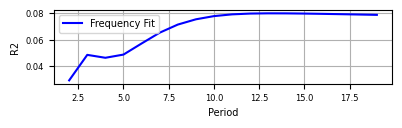

In [97]:
ff(mina = 1, maxa = 360, layer = 1, is_log = True, periods = range(2, 20))

  4%|▍         | 2/50 [00:00<00:10,  4.41it/s]

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


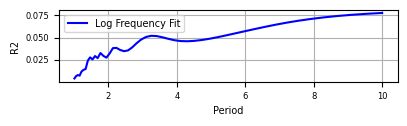

In [112]:
ff(mina = 1, maxa = 360, layer = 1, is_log = True, periods = np.logspace(np.log10(1.01), np.log10(10), 50), periods_to_label=[])